<a href="https://colab.research.google.com/github/hung51607602/COMP3057/blob/main/lenet_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 LeNet-5 Training Demo

## 📌 BEFORE YOU START:

### ✅ Enable GPU:
1. Click **Runtime** → **Change runtime type**
2. Select **GPU** under Hardware accelerator
3. Click **Save**

### 📊 What This Notebook Does:
- Builds LeNet-5 CNN from scratch
- Trains on MNIST with GPU acceleration
- Visualizes training progress
- Tests predictions on sample images
- **Visualizes intermediate feature maps**
- Evaluates model performance

## 🚀 Step 1: Check GPU Availability

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*60)
if torch.cuda.is_available():
    print("✅ GPU IS AVAILABLE!")
    print(f"📍 GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️  WARNING: GPU NOT AVAILABLE!")
    print("👉 Enable GPU: Runtime → Change runtime type → GPU")
print("="*60)
print(f"\n🎯 Using device: {device}")

✅ GPU IS AVAILABLE!
📍 GPU Device: Tesla T4
💾 GPU Memory: 15.83 GB

🎯 Using device: cuda


## 📦 Step 2: Load MNIST Dataset

**MNIST Dataset:**
- 60,000 training images of handwritten digits (0-9)
- 10,000 test images
- Each image is 28×28 pixels, grayscale
- One of the most popular datasets for learning computer vision

**What this cell does:**
1. Downloads MNIST dataset (first time only)
2. Applies transformations: converts to tensor and normalizes
3. Creates DataLoaders for efficient batch processing

### 🔍 Function Explanations

---

#### 1️⃣ `transforms.Compose()`
**Purpose:** Chains multiple data transformation operations together, executing them sequentially

```python
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
```

**How it works:**
- Input image → `ToTensor()` → `Normalize()` → Output processed tensor
- Like a pipeline: data flows through each transformation step in order

---

#### 2️⃣ `transforms.ToTensor()`
**Purpose:** Converts PIL Image or numpy array to PyTorch tensor

**Transformation details:**
```python
# Input:  PIL Image (28, 28), pixel values [0, 255]
# Output: Tensor shape (1, 28, 28), pixel values [0.0, 1.0]
```

**What happens:**
- Converts image from HWC (Height, Width, Channels) to CHW (Channels, Height, Width)
- Scales pixel values from [0, 255] to [0.0, 1.0] by dividing by 255
- Converts data type to `torch.FloatTensor`

**Example:**
```python
# Before: PIL Image, value = 255 (white pixel)
# After:  Tensor, value = 1.0
```
---

#### 3️⃣ `transforms.Normalize(mean, std)`
**Purpose:** Normalizes tensor with given mean and standard deviation

```python
transforms.Normalize((0.1307,), (0.3081,))
# mean = 0.1307
# std  = 0.3081
```

**Formula:**
```
output = (input - mean) / std
```

**Why normalize?**
- Centers data around 0 (mean subtraction)
- Makes training more stable and faster
- Helps gradient descent converge better
- Values for MNIST are pre-calculated from the entire dataset

**Example calculation:**
```python
# Input pixel value: 0.5
# After normalize: (0.5 - 0.1307) / 0.3081 ≈ 1.20
```

---

#### 4️⃣ `datasets.MNIST()`
**Purpose:** Downloads and loads the MNIST dataset

```python
train_dataset = datasets.MNIST(
    root='./data',       # Directory to save/load data
    train=True,          # Load training set (if False, loads test set)
    download=True,       # Download if not already present
    transform=transform  # Apply transformations to each image
)
```

**Parameters explained:**
- `root`: Local folder path where dataset will be stored
- `train`: Boolean flag
  - `True` → 60,000 training images
  - `False` → 10,000 test images
- `download`: Automatically downloads if data not found
- `transform`: Preprocessing function applied to each image when loaded

**What you get:**
```python
len(train_dataset)  # 60,000
train_dataset[0]    # Returns (image_tensor, label)
# image_tensor shape: (1, 28, 28)
# label: int from 0-9
```

---

#### 5️⃣ `DataLoader()`
**Purpose:** Creates an iterator that loads data in batches with optional shuffling and parallel loading

```python
train_loader = DataLoader(
    train_dataset,         # Dataset to load from
    batch_size=64,         # Number of samples per batch
    shuffle=True,          # Randomize order each epoch
    num_workers=2          # Number of subprocesses for data loading
)
```

**Parameters explained:**

**`batch_size=64`**
- Loads 64 images at once instead of one at a time
- Trade-off: Larger = faster training but more GPU memory
- Common values: 32, 64, 128, 256

**`shuffle=True`** (for training)
- Randomizes sample order every epoch
- Prevents model from learning order patterns
- Important for good generalization
- Set to `False` for test set (consistent evaluation)

**`num_workers=2`**
- Number of parallel processes loading data
- Speeds up data loading (CPU task)
- Values: 0 (single process), 2-4 (typical), 8+ (many cores)
- In Colab: 2 is usually good

---

#### 📊 Complete Data Flow

```
Original MNIST Image (28×28 pixels, values 0-255)
          ↓
    ToTensor()
          ↓
    Tensor (1, 28, 28), values [0.0, 1.0]
          ↓
    Normalize(mean=0.1307, std=0.3081)
          ↓
    Normalized Tensor (1, 28, 28), values centered around 0
          ↓
    DataLoader batches into (64, 1, 28, 28)
          ↓
    Ready for model training!
```

---

####🎯 Key Takeaways

| Function | Input | Output | Purpose |
|----------|-------|--------|---------|
| `ToTensor()` | PIL Image | Tensor [0,1] | Convert to PyTorch format |
| `Normalize()` | Tensor [0,1] | Tensor (centered) | Standardize for training |
| `datasets.MNIST()` | - | Dataset object | Access MNIST data |
| `DataLoader()` | Dataset | Batch iterator | Efficient batch loading |

---

#### 💡 Why Each Step Matters

1. **ToTensor()**: Neural networks need numerical tensors, not images
2. **Normalize()**: Makes optimization landscape smoother → faster convergence
3. **MNIST()**: Handles download, storage, and indexing automatically
4. **DataLoader()**: Enables:
   - Batch processing (GPU efficiency)
   - Shuffling (better training)
   - Parallel loading (faster data I/O)

---

#### ❓ Common Questions

**Q: Why normalize with mean=0.1307 and std=0.3081?**
A: These values are calculated from all MNIST images. They center the data around 0 and give it unit variance.

**Q: What if I don't normalize?**
A: Model will still work but may train slower and less stably. Normalization is a best practice.

**Q: Why shuffle training but not test data?**
A: Shuffling prevents the model from learning order patterns. Test set order doesn't matter for evaluation.

**Q: What happens if batch_size is too large?**
A: GPU runs out of memory (CUDA out of memory error). Reduce batch_size if this happens.

**Q: Can I use num_workers > 2?**
A: Yes! Try 4 or 8 if you have many CPU cores. But in Colab, 2 is usually optimal.
```

In [ ]:
print("📥 Downloading MNIST dataset...")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"✅ Training samples: {len(train_dataset)}")
print(f"✅ Test samples: {len(test_dataset)}")

📥 Downloading MNIST dataset...
✅ Training samples: 60000
✅ Test samples: 10000


## 🏗️ Step 3: Define LeNet-5 Model

In [ ]:
# remark
#  模型创建时的执行顺序：
#
# ​__init__方法优先执行​：
#
# - 当你实例化 model = LeNet5()时，Python 会首先调用 __init__方法
# - 在 __init__中：
# - super(LeNet5, self).__init__()首先执行（初始化父类）
# - ​按顺序定义所有层：conv1, conv2, pool, fc1, fc2, fc3, relu
# - 这些层只是被定义，但没有执行任何计算​
#
#
# ​forward方法不会自动执行​：
#
# forward方法在此时不会被调用​
# 它只是一个函数定义，等待后续调用
#
#
# ​.to(device)方法​：
# - 移动模型参数到指定设备


In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()

        # 卷積層 (nn.Conv2d)
        # 池化層 (nn.AvgPool2d
        # ​全連接層 (nn.Linear)​​
        # ​激活函數 (nn.ReLU)​​

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # 将4D特征图转为2D矩阵， -1自动计算batch size； [B,16,5,5] → [B,400]
        x = self.relu(self.fc1(x)) # [B,400] → [B,120]
        x = self.relu(self.fc2(x)) # [B,120] → [B,84]
        x = self.fc3(x)            # [B,84] → [B,10]
        return x

#.to(device): 将模型移动到指定设备
# device需要预先定义，如：
# 目的是： 将所有参数和缓冲区转移到 GPU/CPU
model = LeNet5().to(device)
print("✅ LeNet-5 created!")
print(model)

# 在 (p.numel() for p in model.parameters())中：
# model.parameters()提供参数张量序列
# for p in ...遍历每个参数张量
# p.numel()​转换每个张量为它的参数数量
# 生成器产生一系列数字（每个张量的参数数量）
# 最终 sum()将这些数字相加，得到总参数量。

total_params = sum(p.numel() for p in model.parameters()) # 後面的p會被用到前面的 p.numel() 中計算tensor
# numel()是 PyTorch 张量的方法，p.numel() 就會計算p的所有tensor
print(f"\n📊 Total parameters: {total_params:,}")

✅ LeNet-5 created!
LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)

📊 Total parameters: 61,706


## ⚙️ Step 4: Training Configuration

In [ ]:
learning_rate = 0.001
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("⚙️  Configuration:")
print(f"   Epochs: {num_epochs}")
print(f"   Learning rate: {learning_rate}")
print(f"   Batch size: {batch_size}")
print(f"   Device: {device}")

⚙️  Configuration:
   Epochs: 10
   Learning rate: 0.001
   Batch size: 64
   Device: cuda


## 🎓 Step 5: Training Loop

In [ ]:
train_losses = []
train_accuracies = []
test_accuracies = []

# Training function for one epoch
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one complete pass through the training data
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    correct = 0
    total = 0

    # Progress bar for visual feedback
    pbar = tqdm(train_loader, desc='Training', leave=False)

    for data, target in pbar:
        # Move data to GPU
        data = data.to(device)
        target = target.to(device)

        # Step 1: Clear old gradients
        optimizer.zero_grad()

        # Step 2: Forward pass - make predictions
        output = model(data)

        # Step 3: Calculate loss
        loss = criterion(output, target)

        # Step 4: Backward pass - calculate gradients
        loss.backward()

        # Step 5: Update weights
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        running_loss += loss.item()

        # Update progress bar
        current_acc = 100 * correct / total
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{current_acc:.2f}%'})

    # Calculate average loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc


# Testing function
def test(model, test_loader, device):
    """
    Evaluate the model on test data
    """
    model.eval()  # Set model to evaluation mode

    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed for testing
        for data, target in test_loader:
            # Move data to GPU
            data = data.to(device)
            target = target.to(device)

            # Make predictions
            output = model(data)
            _, predicted = torch.max(output, 1)

            # Calculate accuracy
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    return accuracy


# Start training
print("🚀 Starting Training...\n")
start_time = time.time()

for epoch in range(num_epochs):
    print(f"\n{'='*60}")
    print(f"📅 Epoch [{epoch+1}/{num_epochs}]")
    print(f"{'='*60}")

    # Train for one epoch
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Test on validation set
    test_acc = test(model, test_loader, device)

    # Save results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    # Print results
    print(f"\n📊 Results:")
    print(f"   Train Loss: {train_loss:.4f}")
    print(f"   Train Accuracy: {train_acc:.2f}%")
    print(f"   Test Accuracy: {test_acc:.2f}%")

# Training complete
training_time = time.time() - start_time

print(f"\n{'='*60}")
print("✅ TRAINING COMPLETED!")
print(f"{'='*60}")
print(f"⏱️  Total time: {training_time:.2f} seconds")
print(f"🎯 Final train accuracy: {train_accuracies[-1]:.2f}%")
print(f"🎯 Final test accuracy: {test_accuracies[-1]:.2f}%")
print(f"{'='*60}")

🚀 Starting Training...


📅 Epoch [1/10]


Training:   0%|          | 0/938 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 0.2759
   Train Accuracy: 91.77%
   Test Accuracy: 97.51%

📅 Epoch [2/10]


Training:   0%|          | 0/938 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 0.0781
   Train Accuracy: 97.60%
   Test Accuracy: 97.90%

📅 Epoch [3/10]


Training:   0%|          | 0/938 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 0.0565
   Train Accuracy: 98.20%
   Test Accuracy: 98.33%

📅 Epoch [4/10]


Training:   0%|          | 0/938 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 0.0449
   Train Accuracy: 98.57%
   Test Accuracy: 98.39%

📅 Epoch [5/10]


Training:   0%|          | 0/938 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 0.0382
   Train Accuracy: 98.81%
   Test Accuracy: 98.64%

📅 Epoch [6/10]


Training:   0%|          | 0/938 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 0.0310
   Train Accuracy: 99.01%
   Test Accuracy: 98.91%

📅 Epoch [7/10]


Training:   0%|          | 0/938 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 0.0269
   Train Accuracy: 99.14%
   Test Accuracy: 98.91%

📅 Epoch [8/10]


Training:   0%|          | 0/938 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 0.0225
   Train Accuracy: 99.25%
   Test Accuracy: 98.86%

📅 Epoch [9/10]


Training:   0%|          | 0/938 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 0.0195
   Train Accuracy: 99.35%
   Test Accuracy: 98.74%

📅 Epoch [10/10]


Training:   0%|          | 0/938 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 0.0180
   Train Accuracy: 99.42%
   Test Accuracy: 98.85%

✅ TRAINING COMPLETED!
⏱️  Total time: 189.95 seconds
🎯 Final train accuracy: 99.42%
🎯 Final test accuracy: 98.85%


## 📈 Step 6: Visualize Training Progress

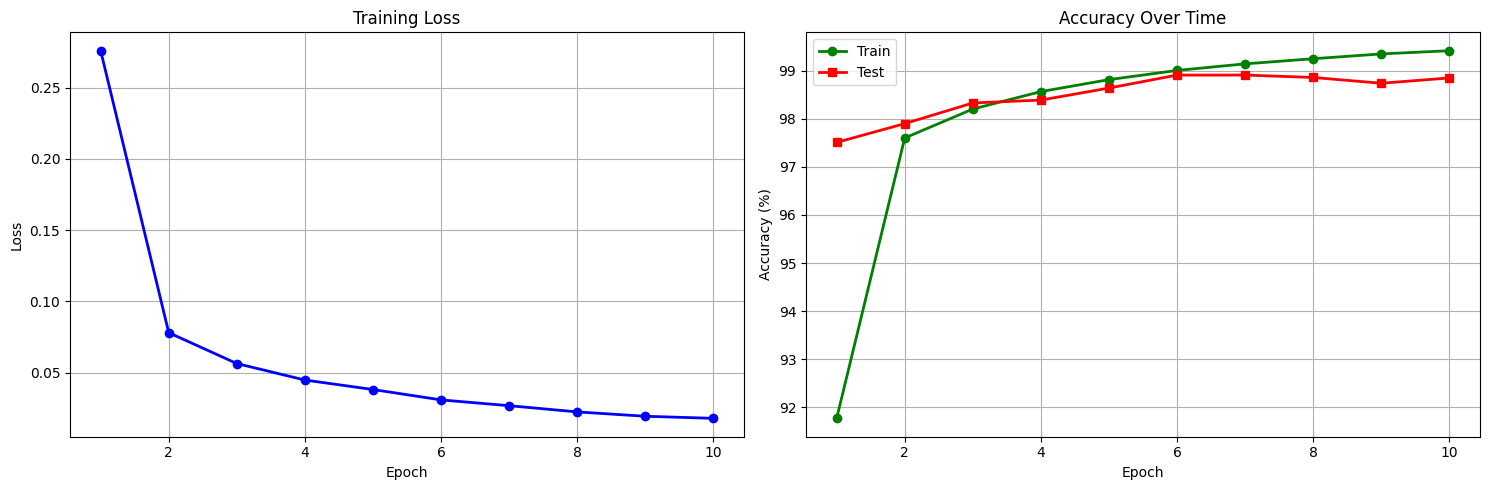

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(1, num_epochs+1), train_losses, 'b-o', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

ax2.plot(range(1, num_epochs+1), train_accuracies, 'g-o', label='Train', linewidth=2)
ax2.plot(range(1, num_epochs+1), test_accuracies, 'r-s', label='Test', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy Over Time')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 🔮 Step 7: Test Predictions

🔍 Making predictions on 18 test images...



/tmp/ipython-input-2129870544.py:55: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


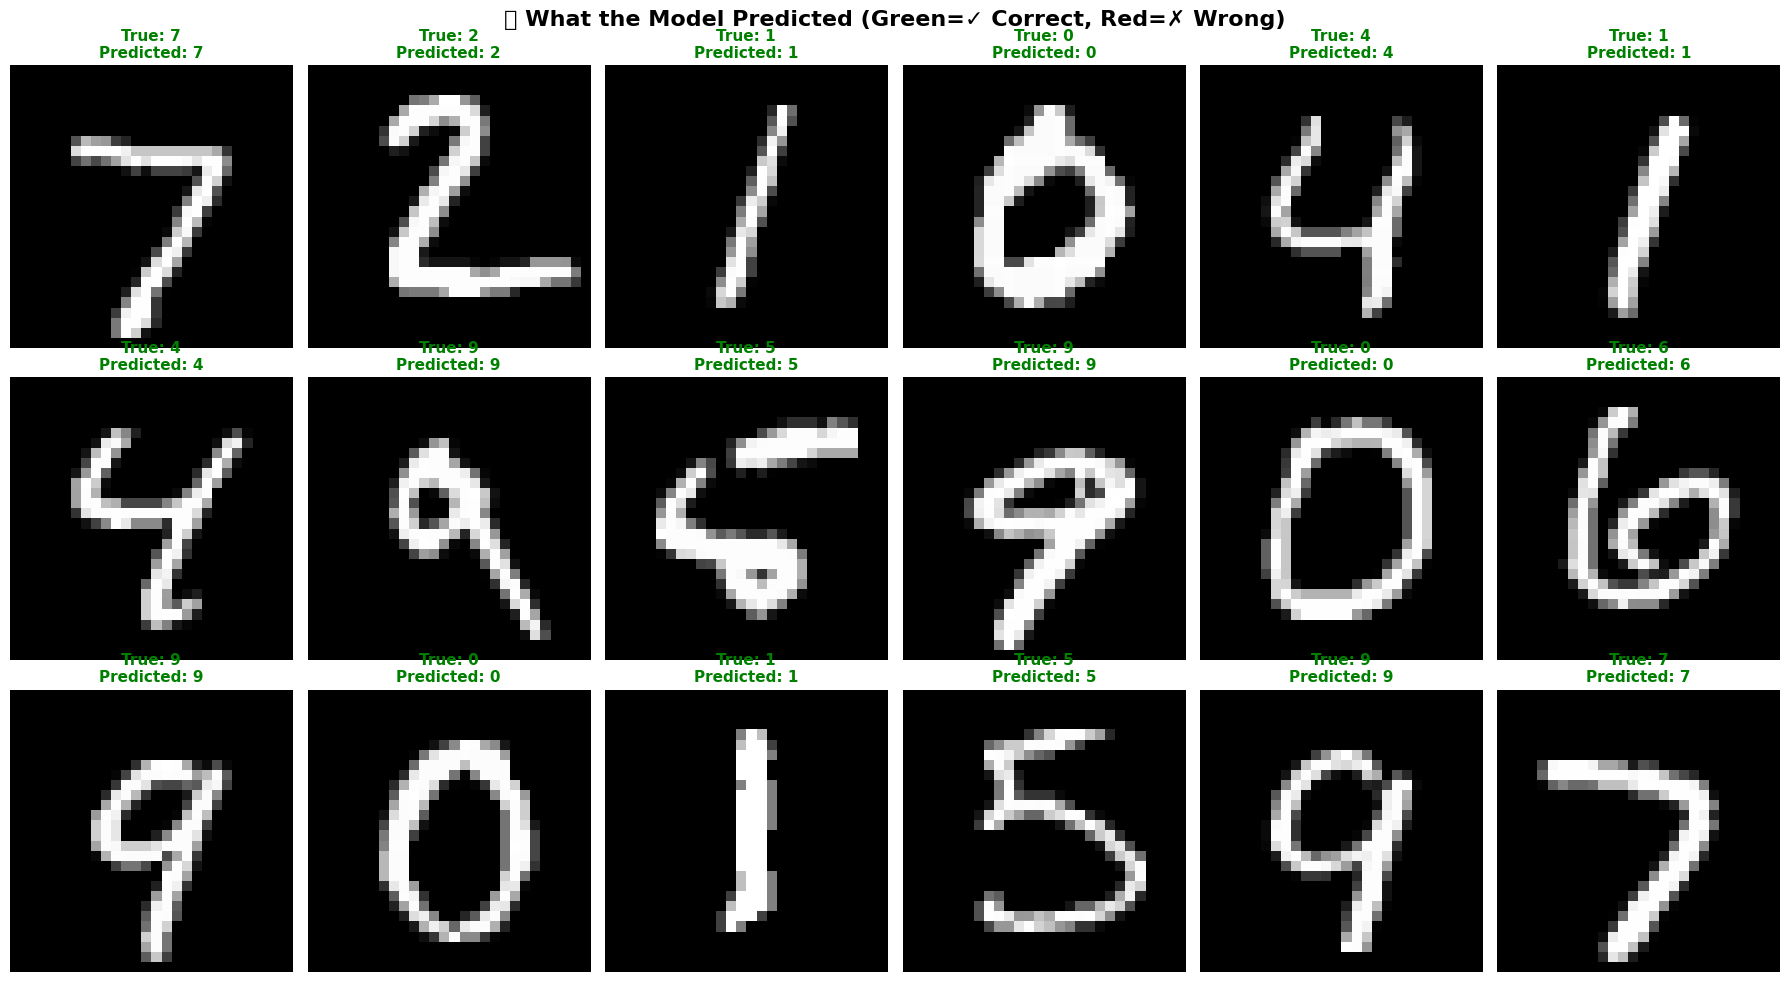

✅ Got 18 out of 18 correct!
📊 Accuracy: 18/18 = 100%


In [ ]:
# Prepare lists to store results
test_images = []
test_labels = []
predictions = []

model.eval()  # Tell model we are testing (not training)

# Test on 18 images
print("🔍 Making predictions on 18 test images...\n")

for i in range(18):
    # Step 1: Get one test image
    image, true_label = test_dataset[i]

    # Step 2: Prepare image for model
    image_for_model = image.unsqueeze(0).to(device)  # Prepare format and send to GPU

    # Step 3: Ask model to predict
    with torch.no_grad():  # Don't calculate gradients (faster)
        output = model(image_for_model)
        predicted_number = output.argmax().item()  # Get the number with highest score

    # Step 4: Save results
    test_images.append(image)
    test_labels.append(true_label)
    predictions.append(predicted_number)

# Visualize the results
fig, axes = plt.subplots(3, 6, figsize=(18, 10))

for i in range(18):
    ax = axes.flat[i]

    # Show the digit image
    ax.imshow(test_images[i].squeeze(), cmap='gray')

    # Check if prediction is correct
    true_number = test_labels[i]
    predicted_number = predictions[i]
    is_correct = (predicted_number == true_number)

    # Color: Green if correct, Red if wrong
    if is_correct:
        color = 'green'
    else:
        color = 'red'

    # Add title showing true label and prediction
    ax.set_title(f"True: {true_number}\nPredicted: {predicted_number}",
                 color=color, fontsize=11, fontweight='bold')
    ax.axis('off')

plt.suptitle('🔮 What the Model Predicted (Green=✓ Correct, Red=✗ Wrong)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Count how many were correct
correct_count = 0
for i in range(18):
    if predictions[i] == test_labels[i]:
        correct_count = correct_count + 1

print(f"✅ Got {correct_count} out of 18 correct!")
print(f"📊 Accuracy: {correct_count}/18 = {correct_count*100//18}%")

## 🔬 Step 8: Visualize Feature Maps

### 🎯 What This Does - Quick Explanation

**Shows what the neural network "sees" at each layer**

---

### 📸 The Visualization

**Original Image** (28×28)
- Your input handwritten digit

**Conv1 Features** (6 filters)
- Detects **simple patterns**: edges, lines, curves
- Each of the 6 filters looks for different basic features

**Conv2 Features** (16 filters)
- Detects **complex patterns**: corners, shapes, digit parts
- Combines Conv1 features into more meaningful structures

---

### 💡 Key Insight

**Brighter areas = Feature detected!**
- White/Yellow = High activation (filter found its pattern)
- Dark/Blue = Low activation (pattern not present)

Different filters activate for different parts of the digit → that's how the network recognizes numbers!

---

### 🧪 What You'll See

```
Input: "7"
├─ Conv1-Filter1: Detects vertical line (right side lights up)
├─ Conv1-Filter2: Detects horizontal line (top lights up)
├─ Conv1-Filter3: Detects diagonal edge
└─ ... etc

Conv2 combines these → recognizes "this is a 7"


**Run the cell multiple times** to see how different digits activate different filters!


Visualizing image #1675



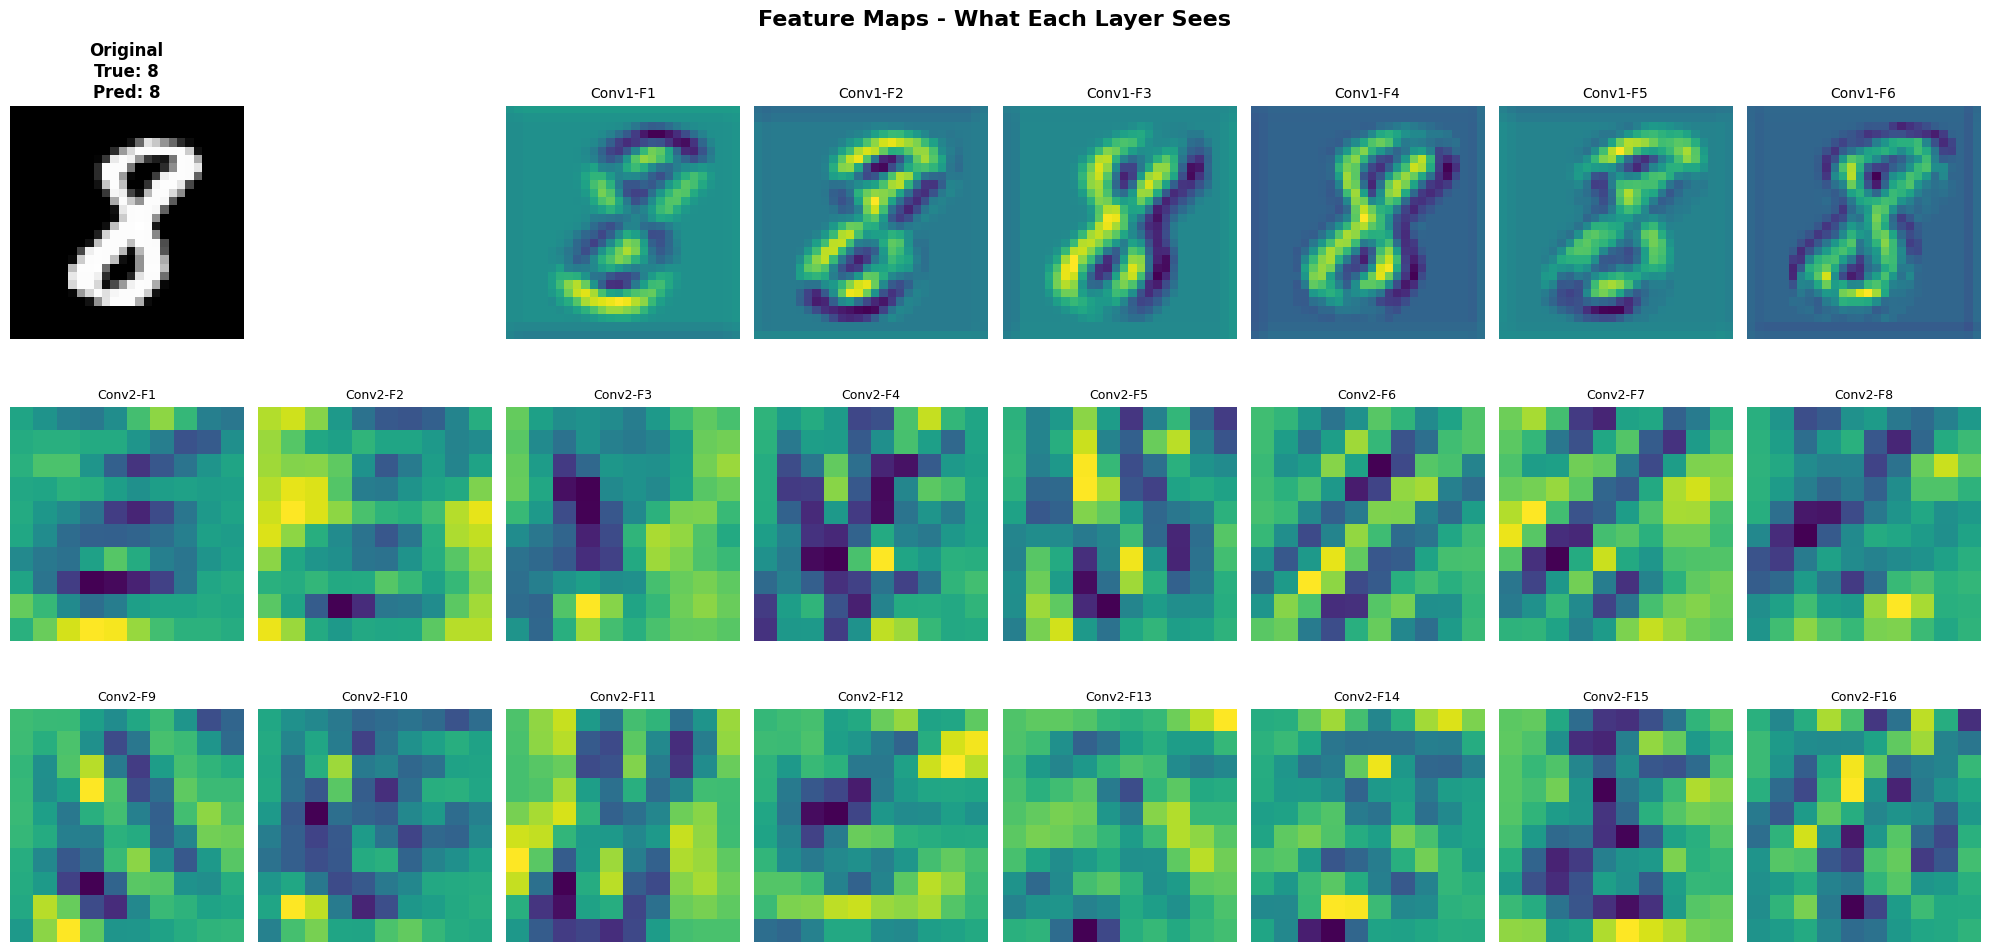

Conv1 output: torch.Size([6, 28, 28])
Conv2 output: torch.Size([16, 10, 10])


In [ ]:
def visualize_feature_maps(model, image, true_label, device):
    model.eval()
    conv1_output = None
    conv2_output = None

    def hook_conv1(module, input, output):
        nonlocal conv1_output
        conv1_output = output

    def hook_conv2(module, input, output):
        nonlocal conv2_output
        conv2_output = output

    hook1 = model.conv1.register_forward_hook(hook_conv1)
    hook2 = model.conv2.register_forward_hook(hook_conv2)

    with torch.no_grad():
        image_gpu = image.unsqueeze(0).to(device)
        output = model(image_gpu)
        _, predicted = torch.max(output, 1)

    hook1.remove()
    hook2.remove()

    conv1_output = conv1_output.cpu().squeeze()
    conv2_output = conv2_output.cpu().squeeze()

    fig = plt.figure(figsize=(20, 10))

    ax = plt.subplot(3, 8, 1)
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'Original\nTrue: {true_label}\nPred: {predicted.item()}', fontsize=12, fontweight='bold')
    ax.axis('off')

    for i in range(6):
        ax = plt.subplot(3, 8, i + 3)
        ax.imshow(conv1_output[i], cmap='viridis')
        ax.set_title(f'Conv1-F{i+1}', fontsize=10)
        ax.axis('off')

    for i in range(16):
        ax = plt.subplot(3, 8, i + 9)
        ax.imshow(conv2_output[i], cmap='viridis')
        ax.set_title(f'Conv2-F{i+1}', fontsize=9)
        ax.axis('off')

    plt.suptitle('Feature Maps - What Each Layer Sees', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"Conv1 output: {conv1_output.shape}")
    print(f"Conv2 output: {conv2_output.shape}")

test_idx = np.random.randint(0, len(test_dataset))
test_image, test_label = test_dataset[test_idx]
print(f"Visualizing image #{test_idx}\n")
visualize_feature_maps(model, test_image, test_label, device)

## 🌡️ Step 9: Activation Heatmap

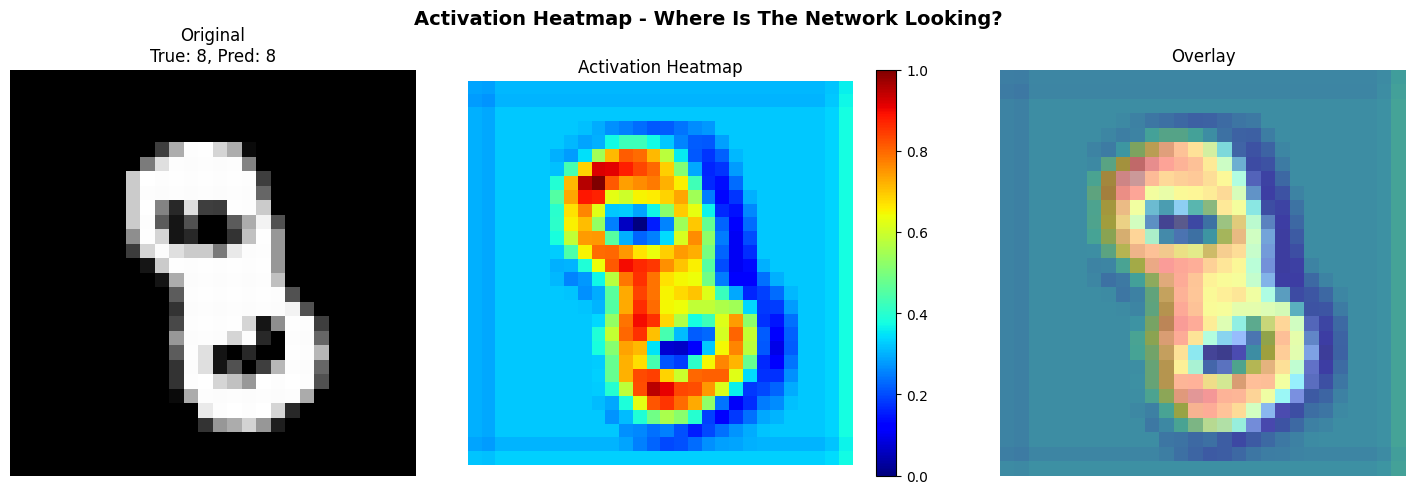

In [ ]:
def visualize_heatmap(model, image, true_label, device):
    model.eval()
    conv1_output = None

    def hook(module, input, output):
        nonlocal conv1_output
        conv1_output = output

    h = model.conv1.register_forward_hook(hook)

    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        _, predicted = torch.max(output, 1)

    h.remove()
    conv1_output = conv1_output.cpu().squeeze()
    heatmap = torch.mean(conv1_output, dim=0)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap_resized = torch.nn.functional.interpolate(
        heatmap.unsqueeze(0).unsqueeze(0), size=(28, 28), mode='bilinear'
    ).squeeze()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image.squeeze(), cmap='gray')
    axes[0].set_title(f'Original\nTrue: {true_label}, Pred: {predicted.item()}', fontsize=12)
    axes[0].axis('off')

    im = axes[1].imshow(heatmap_resized, cmap='jet')
    axes[1].set_title('Activation Heatmap', fontsize=12)
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1])

    axes[2].imshow(image.squeeze(), cmap='gray', alpha=0.6)
    axes[2].imshow(heatmap_resized, cmap='jet', alpha=0.4)
    axes[2].set_title('Overlay', fontsize=12)
    axes[2].axis('off')

    plt.suptitle('Activation Heatmap - Where Is The Network Looking?', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

test_idx = np.random.randint(0, len(test_dataset))
test_image, test_label = test_dataset[test_idx]
visualize_heatmap(model, test_image, test_label, device)

## 💾 Step 10: Save Model

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'final_accuracy': test_accuracies[-1]
}, 'lenet5_mnist.pth')

print("✅ Model saved as lenet5_mnist.pth")
print(f"📊 Final accuracy: {test_accuracies[-1]:.2f}%")

✅ Model saved as lenet5_mnist.pth
📊 Final accuracy: 98.85%


## 🎉 Summary

Congratulations! You have:
- ✅ Built and trained LeNet-5 on MNIST
- ✅ Visualized training progress
- ✅ Explored feature maps and activations
- ✅ Saved the trained model

**Experiment ideas:**
- Try different learning rates
- Add dropout layers
- Train for more epochs
- Test on your own handwritten digits!